In [353]:
!pip install PyMuPDF
!pip install camelot-py[cv] tabula-py
!apt install ghostscript python3-tk
import camelot
import fitz
import PIL

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ghostscript is already the newest version (9.26~dfsg+0-0ubuntu0.18.04.16).
python3-tk is already the newest version (3.6.9-1~18.04).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [354]:
from pandas.core.arrays.sparse import array
import pandas as pd
import numpy as np
import itertools
import re
import json

In [355]:
tables = camelot.read_pdf("aanslagbiljet-test-2021 - test 1.pdf", flavor='stream', split_text=True,table_areas=['250,775,620,650'])
tables

<TableList n=1>

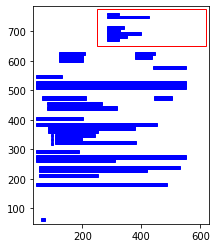

In [356]:
camelot.plot(tables[0], kind='contour').show()

In [357]:
table = tables[0]
klant_info = [value[0] for value in table.df[2:].values]
klant_info

['ABID Abdelkrim',
 'ABID Farida',
 'BOULEVARD SADI CARNOT 58',
 '06110 LE CANNET',
 'FRANKRIJK']

In [358]:
tables = camelot.read_pdf("aanslagbiljet-test-2021 - test 1.pdf", flavor='stream', table_areas=['50,500,620,400'])
camelot.plot(tables[0], kind='contour').show()
tables[0].df

0           1
0                  Het bedrag in uw voordeel:  € 1.572,83
1         O   Terugbetalingsdatum: 30/11/2021            
2  O   Op rekeningnummer: BE17 0004 5674 6021            
3                 Uw rekeningnummer wijzigen?

In [360]:
#Deze code kan aanslagbiljet-documenten lezen
import re
table = tables[0].df
aanslagbiljet_info = {}
table = pd.DataFrame(pd.Series(table.values.tolist()).str.join(""))
#helper methods
pay_receive_by_index = [row.split("€")[0].strip() for row in table.loc[:,0] if "€" in row][0]
amount_to_pay_or_receive_by_index = float([row.split("€")[1].strip() for row in table.loc[:,0] if "€" in row][0].replace(".","").replace(",","."))
aanslagbiljet_info["Te betalen bedrag"] = amount_to_pay_or_receive_by_index
try:
  aanslagbiljet_info["Rekeningnummer"] = re.search("[A-Z].[0-9].*[0-9]",table.loc[table.iloc[:,0].str.contains("rekeningnummer")].values[0][0].split("rekeningnummer: ")[1])[0]
except IndexError: #Franse klant
  aanslagbiljet_info["Rekeningnummer"] = re.search(re.compile("[A-Z].[0-9].*[0-9]"),table.loc[table.iloc[:,0].str.contains("compte bancaire")].values[0][0])[0]
try:
  aanslagbiljet_info["Mededeling"] = re.split(":.",table.loc[table.iloc[:,0].str.contains("mededeling|communication structurée", regex=True, case=False)].values[0][0])[1].strip()  
  aanslagbiljet_info["Vervaldatum"] = re.search("[0-9].\/.*",table.loc[table.iloc[:,0].str.contains("ten laatste|au plus tard le", regex=True, case=False)].values[0][0])[0]
except IndexError: #Terug te krijgen bedrag ipv te betalen
  aanslagbiljet_info["Bedrag in uw voordeel"] = aanslagbiljet_info["Te betalen bedrag"]
  del aanslagbiljet_info["Te betalen bedrag"]

aanslagbiljet_info

{'Bedrag in uw voordeel': 1572.83, 'Rekeningnummer': 'BE17 0004 5674 6021'}

# 2e bladzijde

0  \
0                                
1                                
2            Gegevens aangifte   
3                         Code   
4                         1002   
5                         1094   
6                         1287   
7                                
8                         1084   
9  RESULTAAT VAN DE BEREKENING   

                                                   1     2           3     4  \
0  Deze aanslag werd gevestigd op basis van de vo...                           
1  Gelieve te controleren of deze gegevens correc...                           
2                                                                              
3                                           Gegevens  Code    Gegevens  Code   
4                                                  1  1030           2  1049   
5                                                  1  1250   36.472,23  1286   
6                                             355,08  2049        0,00         
7                           Administratieve gegevens                           
8                                                  1  1086  02/01/1963  2086   
9                                                                              

            5  
0              
1              
2              
3    Gegevens  
4        0,00  
5    6.191,45  
6              
7              
8  02/01/1972  
9

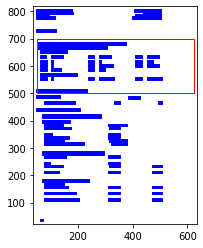

In [361]:
tables = camelot.read_pdf("aanslagbiljet-test-2021 - test 1.pdf", flavor='stream', table_areas=['50,700,625,500'], pages="3")
camelot.plot(tables[0], kind='contour').show()
tables[0].df

In [384]:
df = tables[0].df
start_idx_row = df[df[0].str.contains("[Cc]ode",regex=True, case=True) == True].index[0]
data = df.iloc[start_idx_row:,:].reset_index(drop=True)
data_code_idx = np.where(data.iloc[0,:].str.contains("[Cc]ode", regex=True, case=True)==True)[0]
data_code = data.iloc[:,data_code_idx]
data_amount_idx = np.where(data.iloc[0,:].str.contains("[Gg]egevens|Donnée", regex=True, case=True)==True)[0]
data_amount = data.iloc[:,data_amount_idx]
data_cstacked = pd.DataFrame(data_code.stack()).melt(ignore_index=True)
data_astacked = pd.DataFrame(data_amount.stack()).melt(ignore_index=True)
final_data = pd.concat([data_cstacked, data_astacked], axis=1).drop("variable",axis=1).drop_duplicates()
final_data.columns = final_data.iloc[0]
try:
  final_data = final_data[~final_data['Gegevens'].str.contains("[a-zA-Z]").fillna(False)]
except KeyError:
  final_data = final_data[~final_data['Donnée'].str.contains("[a-zA-Z]").fillna(False)]
final_data = final_data[~final_data['Code'].str.contains("[a-zA-Z]").fillna(False)].reset_index(drop=True)
final_data = final_data[final_data['Code'].map(len) > 0].reset_index(drop=True).T
data_info = final_data.to_dict()

            0     1     2     3          4         5       6     7     8   \
0                                                                           
Code      1002  1030  1049  1094       1250      1286    1287  2049  1084   
Gegevens     1     2  0,00     1  36.472,23  6.191,45  355,08  0,00     1   

                  9           10  
0                                 
Code            1086        2086  
Gegevens  02/01/1963  02/01/1972  


In [385]:
complete_info = json.dumps({"klantinfo":klant_info,"aanslagbiljet":aanslagbiljet_info,"detail":data_info})
complete_info

'{"klantinfo": ["ABID Abdelkrim", "ABID Farida", "BOULEVARD SADI CARNOT 58", "06110 LE CANNET", "FRANKRIJK"], "aanslagbiljet": {"Rekeningnummer": "BE17 0004 5674 6021", "Bedrag in uw voordeel": 1572.83}, "detail": {"0": {"Code": "1002", "Gegevens": "1"}, "1": {"Code": "1030", "Gegevens": "2"}, "2": {"Code": "1049", "Gegevens": "0,00"}, "3": {"Code": "1094", "Gegevens": "1"}, "4": {"Code": "1250", "Gegevens": "36.472,23"}, "5": {"Code": "1286", "Gegevens": "6.191,45"}, "6": {"Code": "1287", "Gegevens": "355,08"}, "7": {"Code": "2049", "Gegevens": "0,00"}, "8": {"Code": "1084", "Gegevens": "1"}, "9": {"Code": "1086", "Gegevens": "02/01/1963"}, "10": {"Code": "2086", "Gegevens": "02/01/1972"}}}'